# Substrate index compare

__Main author:__  Cole Fields  
__Affiliation:__  Fisheries and Oceans Canada (DFO)   
__Group:__        Marine Spatial Ecology and Analysis   
__Location:__     Institute of Ocean Sciences   
__Contact:__      e-mail: Cole.Fields@dfo-mpo.gc.ca | tel: 250-363-8060

## Modules <a class="anchor" id="Modules"></a>

In [1]:
# import modules
import os
import glob
import rasterio as rio
import logging
import traceback
from pathlib import Path
from rasterio.plot import show_hist
from rasterio.plot import show
import earthpy.plot as ep
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from osgeo import gdal

## Functions <a class="anchor" id="Functions"></a>

In [2]:
# functions
def create_outdir(in_dir, prefix):
    """
    Change to input (working) directory.
    Make an output directory for new files.
    :param in_dir: input directory.
    :param prefix: region.
    :return: output directory path.
    """
    # setup logging, change to input dir, make output directory
    try:
        # create output directory
        os.chdir(in_dir)
        out_path = in_dir / ("output_" + prefix)
        logging.info("Creating output directory: {}".format(out_path))
        Path(out_path).mkdir(exist_ok=True)
        logging.info("Changing directory to: {}".format(out_path))
        os.chdir(out_path)
        return out_path
    except Exception:
        logging.error(traceback.format_exc())
        
        
def list_tiffs(directory):
    """
    Get a list of TIFF filepaths.
    :param in_dir: input directory.
    :return: list of file names for tiffs.
    """
    try:
        os.chdir(directory)
        logging.info("Getting names of GeoTIFFs...")
        files = [file for file in glob.glob("*.tif")]
        logging.info("Number of GeoTIFFS in %s: %s" % (directory, len(files)))
        return files
    except Exception:
        logging.error(traceback.format_exc())


def subset_tiffs(directory, prefix, index_layer):
    """
    Subset GeoTIFF files by region (prefix) and method (rf or ranger).
    :param directory: input directory.
    :param prefix: region.
    :param index_layer: substrate type (rocky, mixed, sandy, muddy).
    :return: dict with 2 lists of file names for GeoTIFFs subsetted by region and method.
    """
    try:
        # subset files using regional prefix (such as 'hg' or 'ncc'), index type (such as 'rocky') and the method ('_rf' or '_ranger')
        os.chdir(directory)
        logging.info("Subsetting GeoTIFFs by {} and {}...".format(prefix, index_layer))
        rf_file = [file for file in glob.glob("{}_{}_rf.tif".format(prefix, index_layer))]
        ranger_file = [file for file in glob.glob("{}_{}_ranger.tif".format(prefix, index_layer))]
        files_dict = {"rf": rf_file, "ranger": ranger_file}
        for k, v in files_dict.items():
            logging.info("{}: {}".format(k, v))
        return files_dict
    except Exception:
        logging.error(traceback.format_exc())   
        

def calc_stats(dataset):
    """
    Calculate statistics for a raster dataset.
    :param dataset: GeoTIFF file path.
    :return: raster stats.
    """
    try:
        logging.info("Calculating statistics for {}...".format(dataset))
        raster = gdal.Info(dataset, stats=True)
        return raster
    except Exception:
        logging.error(traceback.format_exc())  

        
def make_array(file):
    """
    Create numpy array from raster file.
    :param files: file.
    :return: raster array.
    """
    try:
        with rio.open(file) as dataset:
            logging.info("Creating arrays for analysis...")
            dataset_array = dataset.read(1, masked=True)
            return dataset_array
    except Exception:
        logging.error(traceback.format_exc())     

    
def raster_info(file_dict, working_dir, method):
    """
    Get raster properties
    :param file_dict: dict with 2 lists of file names for GeoTIFF files subsetted by method.
    :param working_dir: working directory with GeoTIFF files are.
    :param method: rf or ranger for method.
    :return: dictionary with raster information (extent, spatial ref, profile)
    """
    try:
        with rio.open(working_dir / file_dict.get(method)[0]) as src:
            logging.info("Creating dictionary with raster information...")
            rast_dict = {"type": type(src)}
            rast_dict.update({"crs": src.crs})
            rast_dict.update({"bounds": src.bounds})
            rast_dict.update({"profile": src.profile})
            rast_dict.update({"shape": src.shape})
        return rast_dict
    except Exception:
        logging.error(traceback.format_exc())   
    
        
def subtract_rasters(file_dict, working_dir, output_dir, prefix, index_layer):
    """
    Create an array of the difference between the random forest and ranger layers; write GeoTIFF to disk.
    :param file_dict: dict with 2 lists of file names for tiffs subsetted by method.
    :param working_dir: input directory
    :param output_dir: input directory
    :param prefix: region name
    :return: array of values (random forest - ranger)
    """

    try:
        with rio.open(working_dir / file_dict.get("rf")[0]) as rf:
            logging.info("Creating arrays for analysis...")
            rf_substrate = rf.read(1, masked=True)
            rf_meta = rf.profile
            # Convert no data to nan.
#             nodata = rf.nodatavals
#             rf_substrate[rf_substrate == nodata] = "nan"
            
        # open ranger model
        with rio.open(working_dir / file_dict.get("ranger")[0]) as ranger:
            ranger_substrate = ranger.read(1, masked=True)
            ranger_meta = ranger.profile
            # Convert no data to nan.
#             nodata = ranger.nodatavals
#             ranger_substrate[ranger_substrate == nodata] = "nan"

        # subtract random forest from ranger
        logging.info("Subtracting random forest array from ranger array ...")
        array_subtract = ranger_substrate - rf_substrate
        out_name = prefix + "_" + index_layer + "_diff.tif"
        outfile = output_dir / out_name

        with rio.Env():
            # Update profile
            ranger_meta.update(
                compress="lzw")
            # Write raster
            logging.info("Saving GeoTIFF of difference as {}...".format(out_name))
            with rio.open(outfile, 'w', **ranger_meta) as dataset:
                dataset.write(array_subtract.astype(rio.float32), 1)

        # return array of values (rf - ranger)
        return array_subtract
    except Exception:
        logging.error(traceback.format_exc())   
    
    
def set_nodata(file):
    """
    Set NoData values.
    :param file: GeoTIFF file name.
    :return: 
    """
    try:
        nodata = -9999
        # open the file for editing
        ras = gdal.Open(file)
        # get raster band and set nodata value
        ras.GetRasterBand(1).SetNoDataValue(nodata)
        # unlink the file object and save the results
        ras = None
        return
    except Exception:
        logging.error(traceback.format_exc())   
    
    
def hist(array, prefix, index_layer, bins, size, output_dir):
    """
    Plot histogram example.
    :param array: array of values for histogram.
    :param prefix: region.
    :param index_layer: substrate type (rocky, mixed, sandy, muddy).
    :param bins: bins for grouping data.
    :param size: figure size.
    :return: figure object.
    """
    try:
        fig, axhist = plt.subplots(1, figsize=(size, size))
        show_hist(array, bins=bins, histtype="stepfilled",
                  lw=0.0, stacked=False, alpha=0.5, ax=axhist)
        axhist.set_xlabel("Difference")
        axhist.set_ylabel("Frequency")
        axhist.set_title("Difference between randomForest model and ranger model \nRegion: {}\nIndex: {}".format(prefix, index_layer),)
        axhist.ticklabel_format(useOffset=False, style='plain')
        fig_name = "{}_{}_hist.pdf".format(prefix, index_layer)
        outfile = output_dir / fig_name
        fig.savefig("{}".format(outfile))
        return fig
    except Exception:
        logging.error(traceback.format_exc())    


def plot_raster(array, prefix, index_layer, size, output_dir):
    """
    Plot rasters using diverging color ramp.
    :param array: array of difference between rf model and ranger model.
    :param prefix: region.
    :param index_layer: substrate type (rocky, mixed, sandy, muddy).
    :param size: integer for figure size.
    :return: figure.
    """
    try:
        fig, ax = plt.subplots(1, figsize=(size, size))
        ep.plot_bands(array,
                      cmap="coolwarm",
                      title="Difference between ranger model and randomForest model \nRegion: {}\nIndex: {}".format(prefix, index_layer),
                      ax=ax)
        plt.show()
        fig_name = "{}_{}_diff.pdf".format(prefix, index_layer)
        outfile = output_dir / fig_name
        fig.savefig("{}".format(outfile))
        return fig
    except Exception:
        logging.error(traceback.format_exc())  

## Setup <a class="anchor" id="setup"></a>

* Set INPUT_DIRECTORY to a directory that has the GeoTIFF files to be used for analysis.
* Expected naming convention for files is region_substrate_method.tif such as coast_mixed_ranger.tif

In [89]:
# set up global variables
# input directory as Windows Path object
INPUT_DIRECTORY = Path("D:/projects/substrate/rf-ranger-compare/data")
# index layer ("rocky", "mixed", "sandy", "muddy")
INDEX_LYR = ["rocky", "mixed", "sandy", "muddy"]
# figure size for plots
FIG_SIZE = 18

# set up logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)
# set up stream handler
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)
formatter = logging.Formatter("%(asctime)s:%(levelname)s: - %(message)s")
handler.setFormatter(formatter)

# override default handler settings
logger.handlers = [handler]

## Shelf <a class="anchor" id="Shelf"></a>

2021-01-11 10:13:55,757:INFO: - Creating output directory: D:\projects\substrate\rf-ranger-compare\data\output_coast
2021-01-11 10:13:55,758:INFO: - Changing directory to: D:\projects\substrate\rf-ranger-compare\data\output_coast
2021-01-11 10:13:55,759:INFO: - Output directory: D:\projects\substrate\rf-ranger-compare\data\output_coast
2021-01-11 10:13:55,760:INFO: - Subsetting GeoTIFFs by coast and rocky...
2021-01-11 10:13:55,761:INFO: - rf: ['coast_rocky_rf.tif']
2021-01-11 10:13:55,761:INFO: - ranger: ['coast_rocky_ranger.tif']
2021-01-11 10:13:55,762:INFO: - Subsetting GeoTIFFs by coast and mixed...
2021-01-11 10:13:55,763:INFO: - rf: ['coast_mixed_rf.tif']
2021-01-11 10:13:55,763:INFO: - ranger: ['coast_mixed_ranger.tif']
2021-01-11 10:13:55,763:INFO: - Subsetting GeoTIFFs by coast and sandy...
2021-01-11 10:13:55,764:INFO: - rf: ['coast_sandy_rf.tif']
2021-01-11 10:13:55,765:INFO: - ranger: ['coast_sandy_ranger.tif']
2021-01-11 10:13:55,765:INFO: - Subsetting GeoTIFFs by coast a

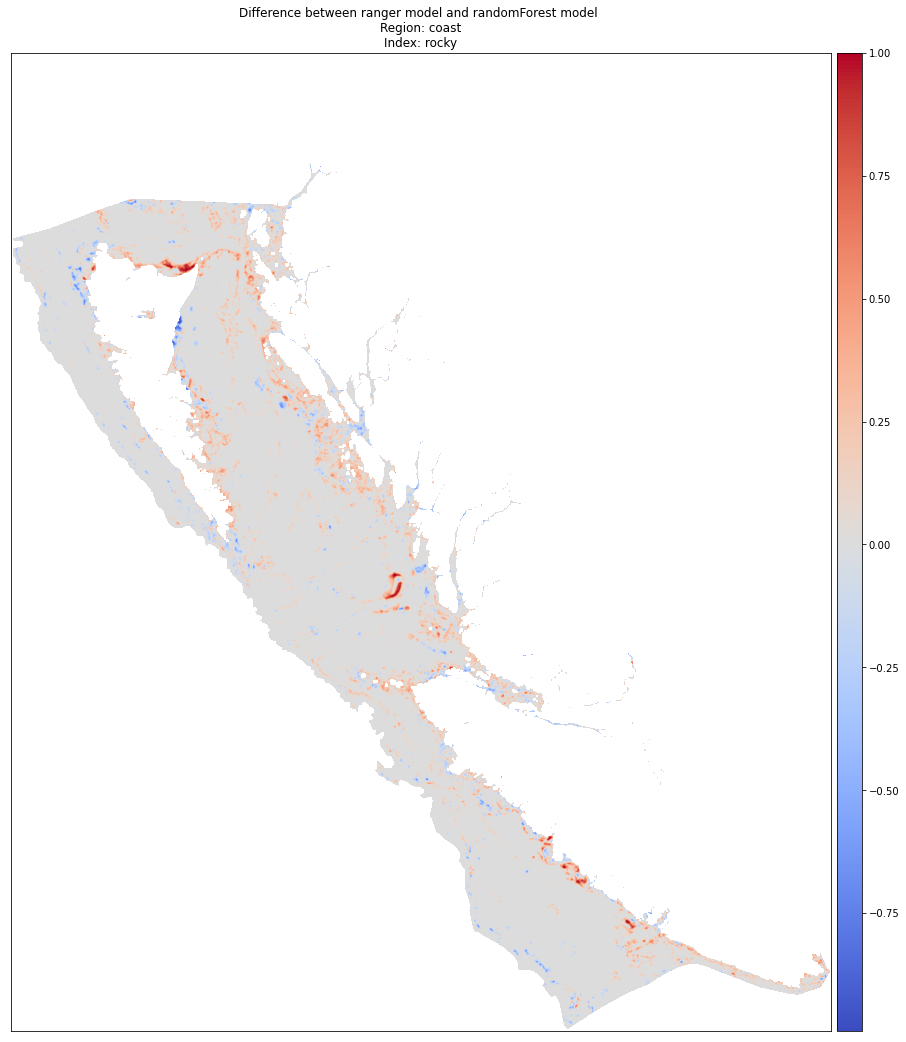

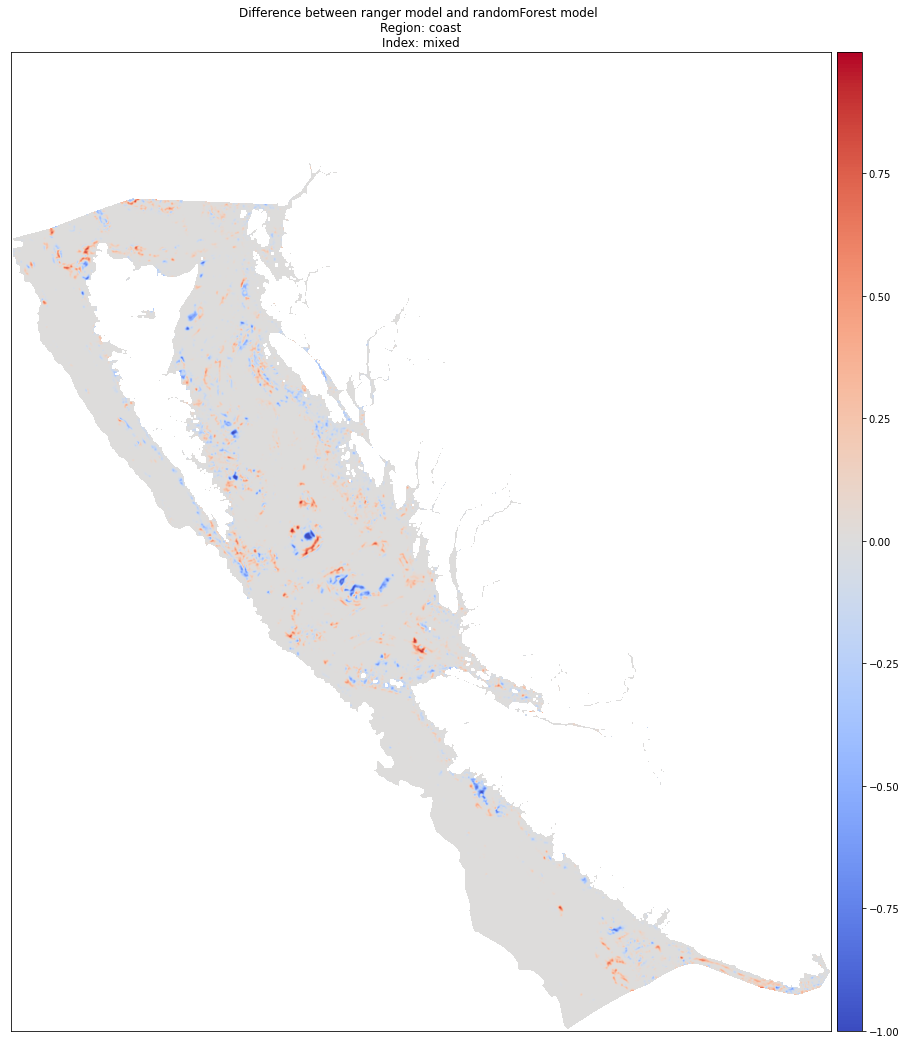

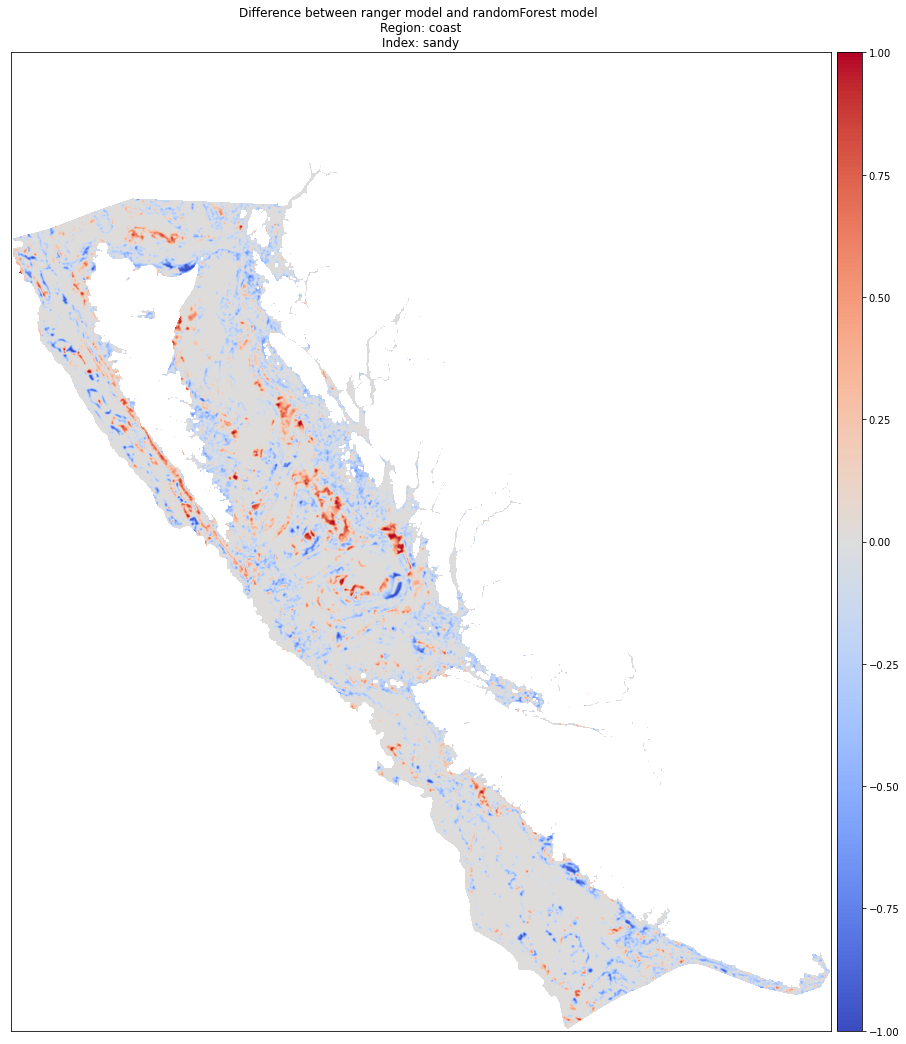

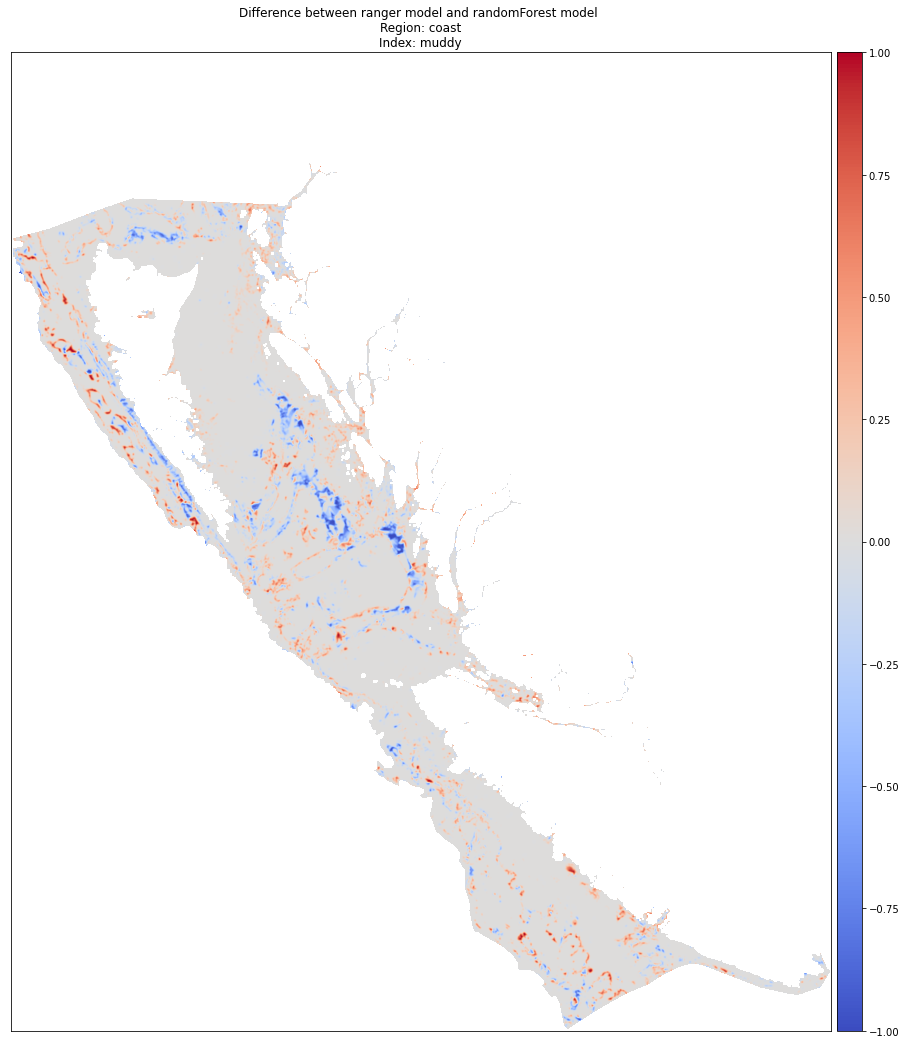

2021-01-11 10:14:37,781:INFO: - Getting names of GeoTIFFs...
2021-01-11 10:14:37,782:INFO: - Number of GeoTIFFS in D:\projects\substrate\rf-ranger-compare\data\output_coast: 4
2021-01-11 10:14:37,782:INFO: - Calculating statistics for coast_mixed_diff.tif...
2021-01-11 10:14:38,702:INFO: - Calculating statistics for coast_muddy_diff.tif...
2021-01-11 10:14:39,745:INFO: - Calculating statistics for coast_rocky_diff.tif...
2021-01-11 10:14:40,698:INFO: - Calculating statistics for coast_sandy_diff.tif...


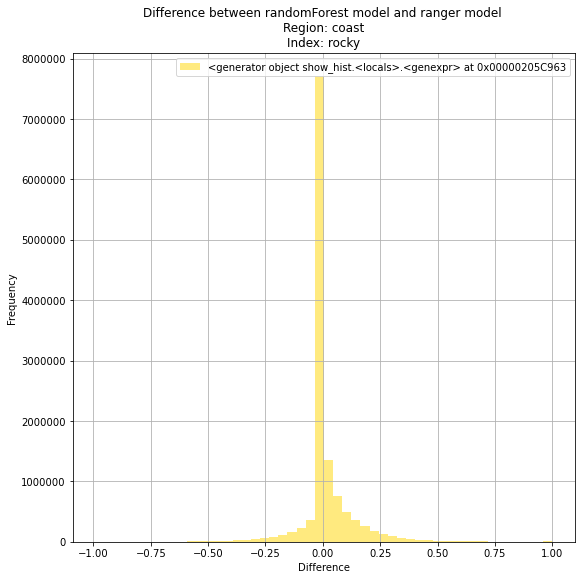

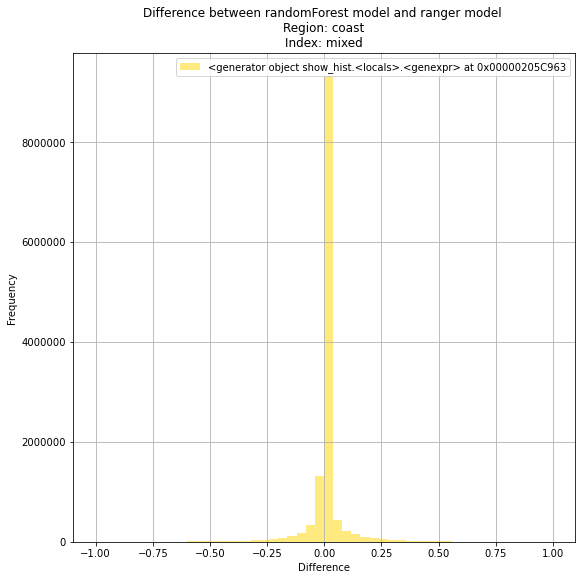

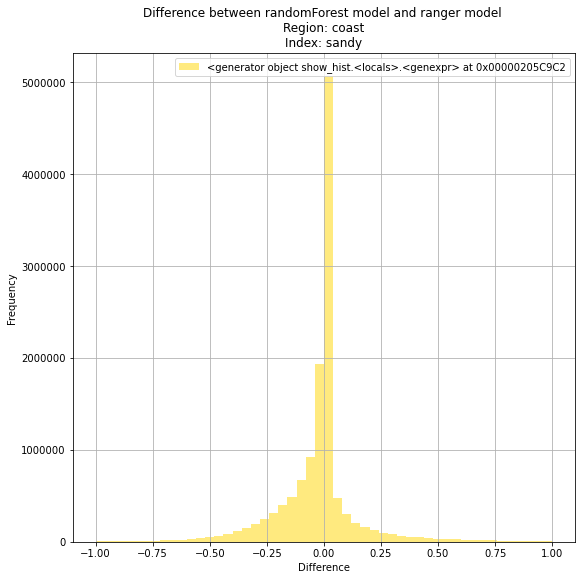

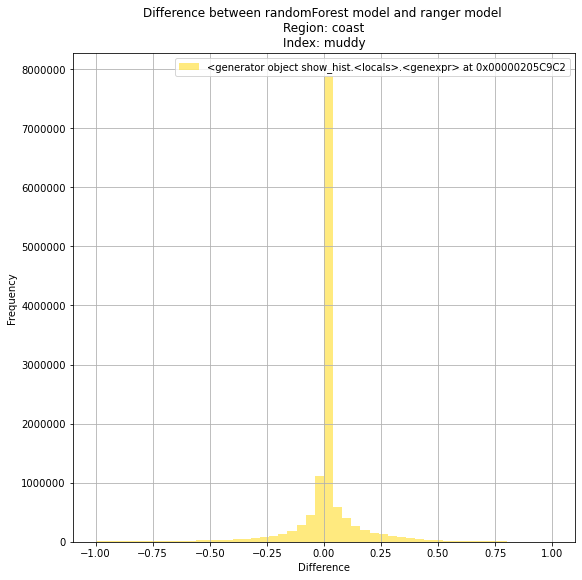

In [86]:
# prefix for region ("coast", "ncc", "hg", "qcs", "wcvi", "sog")
prefix = "coast"
# set output directory
out_dir = create_outdir(INPUT_DIRECTORY, prefix)
logging.info("Output directory: {}".format(out_dir))

# subset tiffs by method and region prefix
model_dicts = [subset_tiffs(INPUT_DIRECTORY, prefix, idx) for idx in INDEX_LYR]
# create difference arrays
diffs = [subtract_rasters(model_dict, INPUT_DIRECTORY, out_dir, prefix, idx) for model_dict, idx in zip(model_dicts, INDEX_LYR)] 
# plot results
plts = [plot_raster(array, prefix, idx, FIG_SIZE, out_dir) for array, idx in zip(diffs, INDEX_LYR)] 
# list of output tiffs
diff_tiffs = list_tiffs(out_dir)
# calc stats on output tiffs
stats = [calc_stats(tiff) for tiff in diff_tiffs]
# plot histograms of difference
hists = [hist(array, prefix, idx, 50, FIG_SIZE/2, out_dir) for array, idx in zip(diffs, INDEX_LYR)] 

## West Coast Vancouver Island <a class="anchor" id="West-Coast-Vancouver-Island"></a>

2021-01-11 09:25:52,042:INFO: - Creating output directory: D:\projects\substrate\rf-ranger-compare\data\output_wcvi
2021-01-11 09:25:52,043:INFO: - Changing directory to: D:\projects\substrate\rf-ranger-compare\data\output_wcvi
2021-01-11 09:25:52,044:INFO: - Output directory: D:\projects\substrate\rf-ranger-compare\data\output_wcvi
2021-01-11 09:25:52,045:INFO: - Subsetting GeoTIFFs by wcvi and rocky...
2021-01-11 09:25:52,046:INFO: - rf: ['wcvi_rocky_rf.tif']
2021-01-11 09:25:52,046:INFO: - ranger: ['wcvi_rocky_ranger.tif']
2021-01-11 09:25:52,046:INFO: - Subsetting GeoTIFFs by wcvi and mixed...
2021-01-11 09:25:52,047:INFO: - rf: ['wcvi_mixed_rf.tif']
2021-01-11 09:25:52,048:INFO: - ranger: ['wcvi_mixed_ranger.tif']
2021-01-11 09:25:52,048:INFO: - Subsetting GeoTIFFs by wcvi and sandy...
2021-01-11 09:25:52,049:INFO: - rf: ['wcvi_sandy_rf.tif']
2021-01-11 09:25:52,049:INFO: - ranger: ['wcvi_sandy_ranger.tif']
2021-01-11 09:25:52,049:INFO: - Subsetting GeoTIFFs by wcvi and muddy...
2

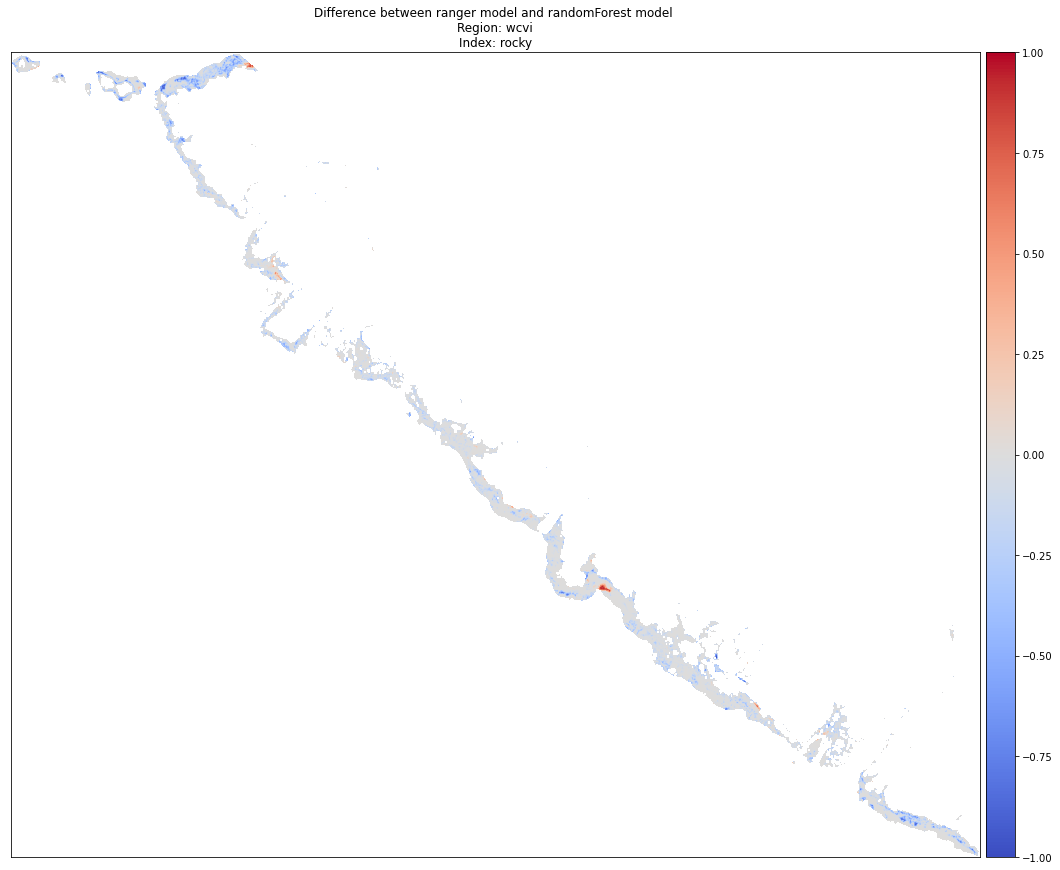

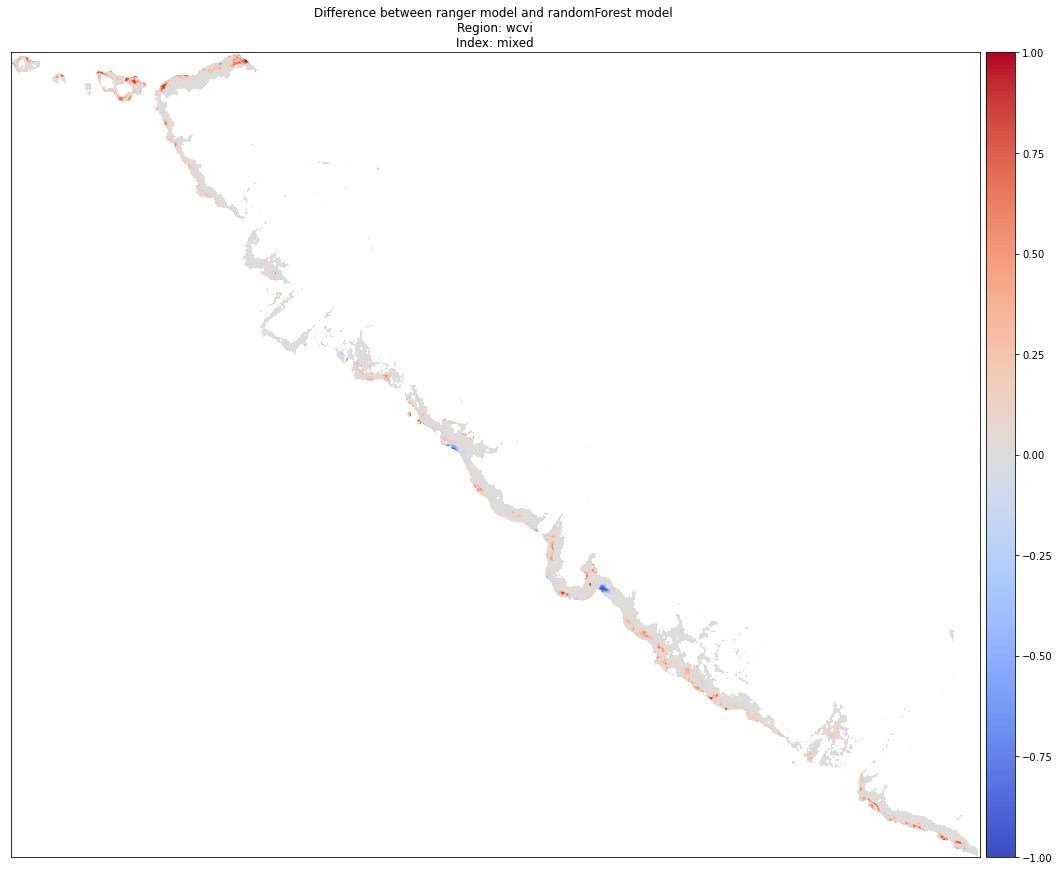

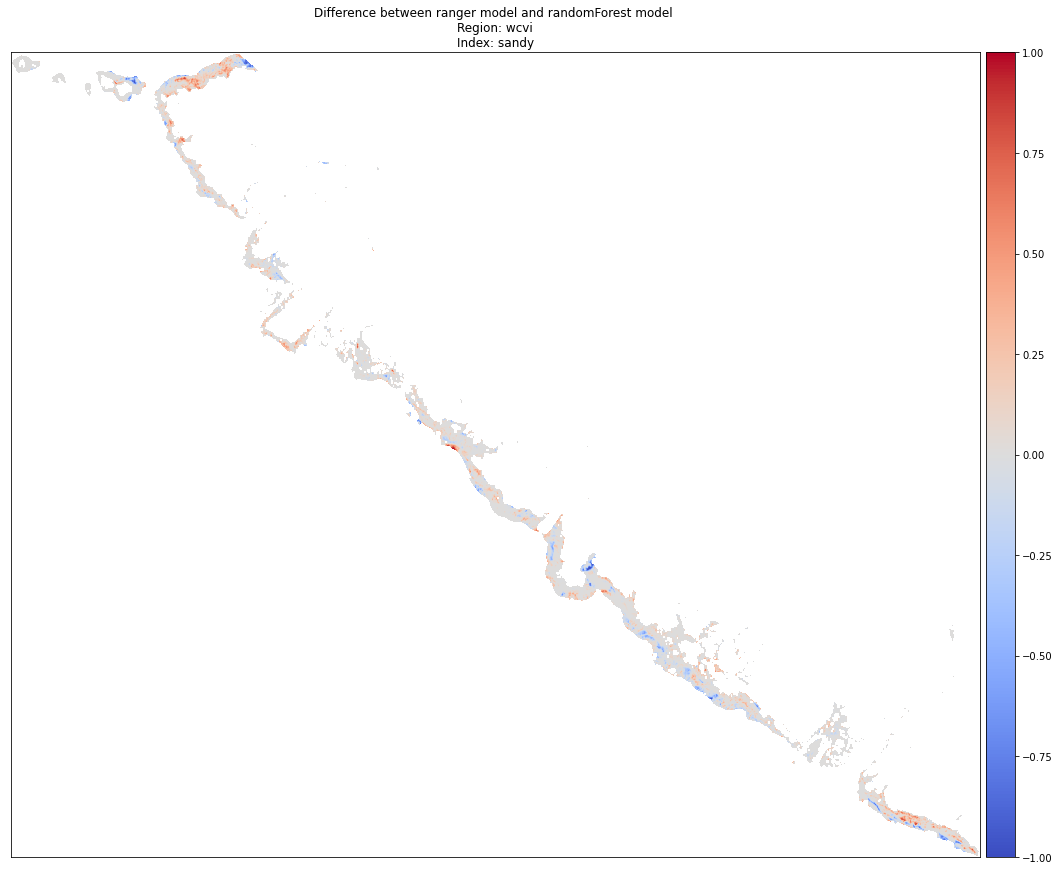

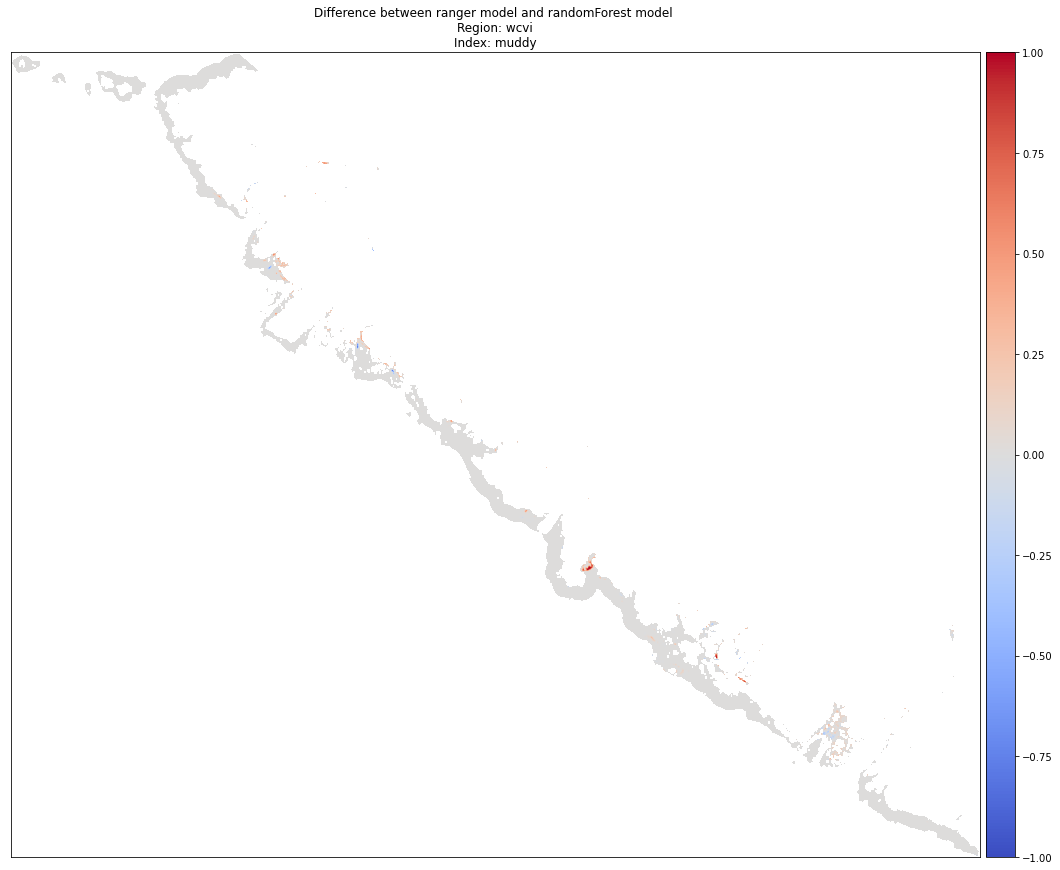

2021-01-11 09:27:56,407:INFO: - Getting names of GeoTIFFs...
2021-01-11 09:27:56,408:INFO: - Number of GeoTIFFS in D:\projects\substrate\rf-ranger-compare\data\output_wcvi: 4
2021-01-11 09:27:56,408:INFO: - Calculating statistics for wcvi_mixed_diff.tif...
2021-01-11 09:27:59,068:INFO: - Calculating statistics for wcvi_muddy_diff.tif...
2021-01-11 09:28:01,713:INFO: - Calculating statistics for wcvi_rocky_diff.tif...
2021-01-11 09:28:04,572:INFO: - Calculating statistics for wcvi_sandy_diff.tif...


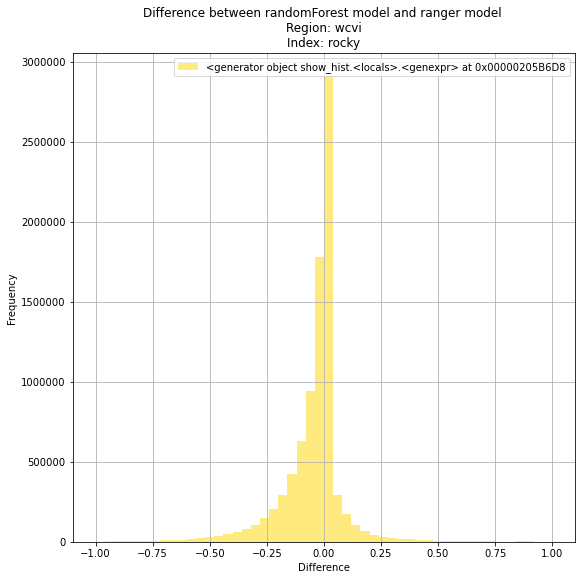

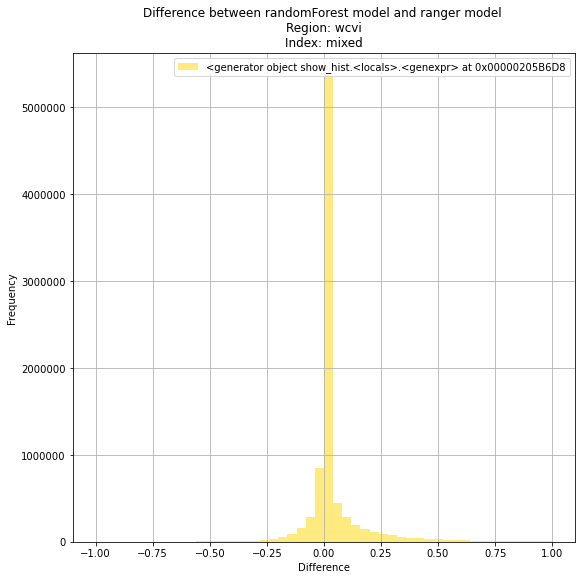

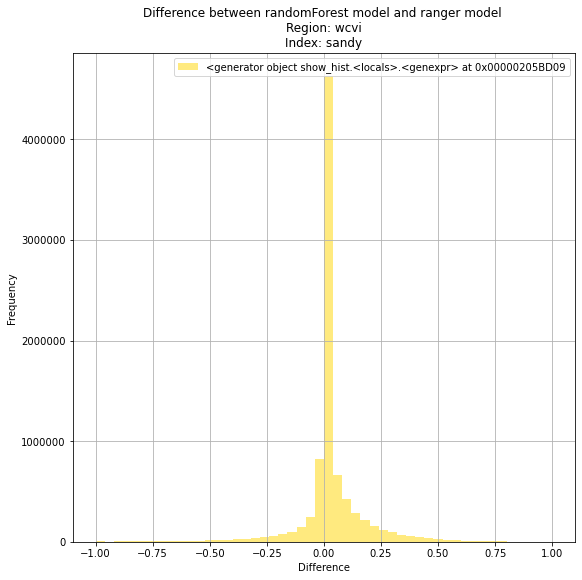

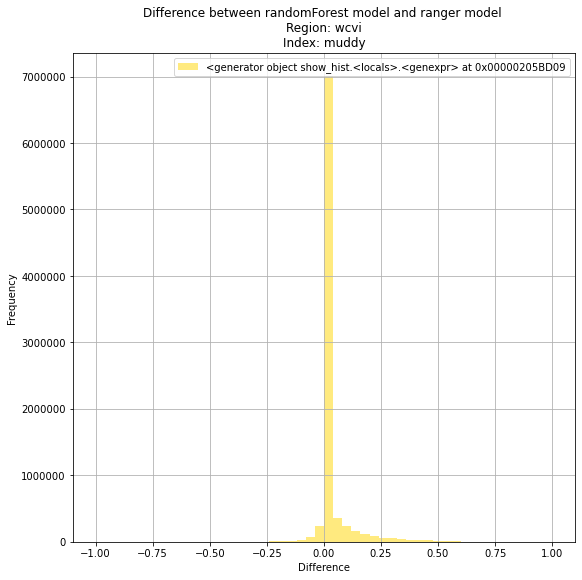

In [81]:
# prefix for region ("coast", "ncc", "hg", "qcs", "wcvi", "sog")
prefix = "wcvi"
# set output directory
out_dir = create_outdir(INPUT_DIRECTORY, prefix)
logging.info("Output directory: {}".format(out_dir))

# subset tiffs by method and region prefix
model_dicts = [subset_tiffs(INPUT_DIRECTORY, prefix, idx) for idx in INDEX_LYR]
# create difference arrays
diffs = [subtract_rasters(model_dict, INPUT_DIRECTORY, out_dir, prefix, idx) for model_dict, idx in zip(model_dicts, INDEX_LYR)] 
# plot results
plts = [plot_raster(array, prefix, idx, FIG_SIZE, out_dir) for array, idx in zip(diffs, INDEX_LYR)] 
# list of output tiffs
diff_tiffs = list_tiffs(out_dir)
# calc stats on output tiffs
stats = [calc_stats(tiff) for tiff in diff_tiffs]
# plot histograms of difference
hists = [hist(array, prefix, idx, 50, FIG_SIZE/2, out_dir) for array, idx in zip(diffs, INDEX_LYR)] 

## Haida Gwaii <a class="anchor" id="Haida-Gwaii"></a>

2021-01-11 09:23:29,703:INFO: - Creating output directory: D:\projects\substrate\rf-ranger-compare\data\output_hg
2021-01-11 09:23:29,704:INFO: - Changing directory to: D:\projects\substrate\rf-ranger-compare\data\output_hg
2021-01-11 09:23:29,705:INFO: - Output directory: D:\projects\substrate\rf-ranger-compare\data\output_hg
2021-01-11 09:23:29,706:INFO: - Subsetting GeoTIFFs by hg and rocky...
2021-01-11 09:23:29,707:INFO: - rf: ['hg_rocky_rf.tif']
2021-01-11 09:23:29,707:INFO: - ranger: ['hg_rocky_ranger.tif']
2021-01-11 09:23:29,708:INFO: - Subsetting GeoTIFFs by hg and mixed...
2021-01-11 09:23:29,708:INFO: - rf: ['hg_mixed_rf.tif']
2021-01-11 09:23:29,709:INFO: - ranger: ['hg_mixed_ranger.tif']
2021-01-11 09:23:29,709:INFO: - Subsetting GeoTIFFs by hg and sandy...
2021-01-11 09:23:29,710:INFO: - rf: ['hg_sandy_rf.tif']
2021-01-11 09:23:29,711:INFO: - ranger: ['hg_sandy_ranger.tif']
2021-01-11 09:23:29,711:INFO: - Subsetting GeoTIFFs by hg and muddy...
2021-01-11 09:23:29,712:INF

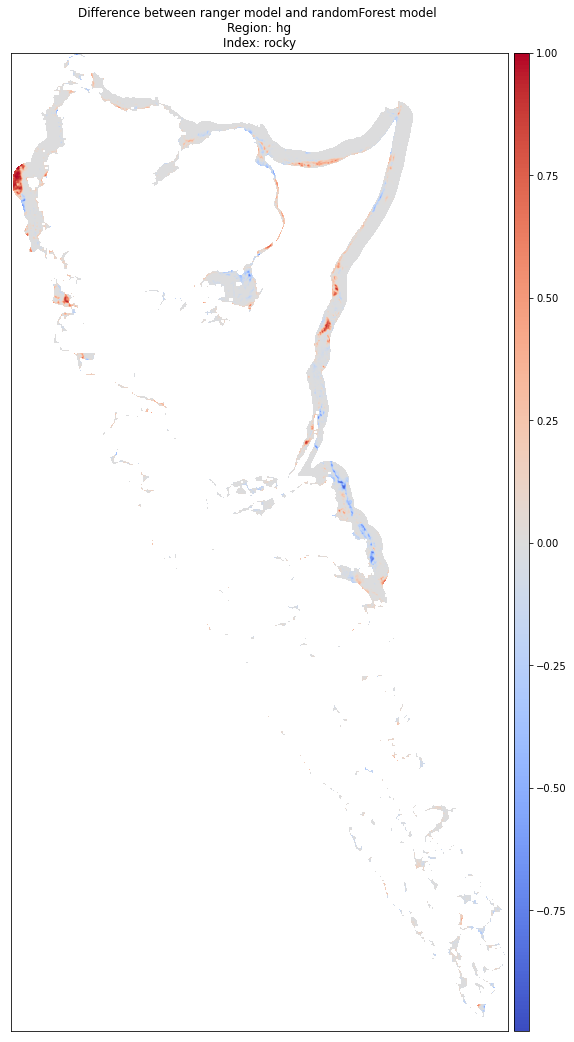

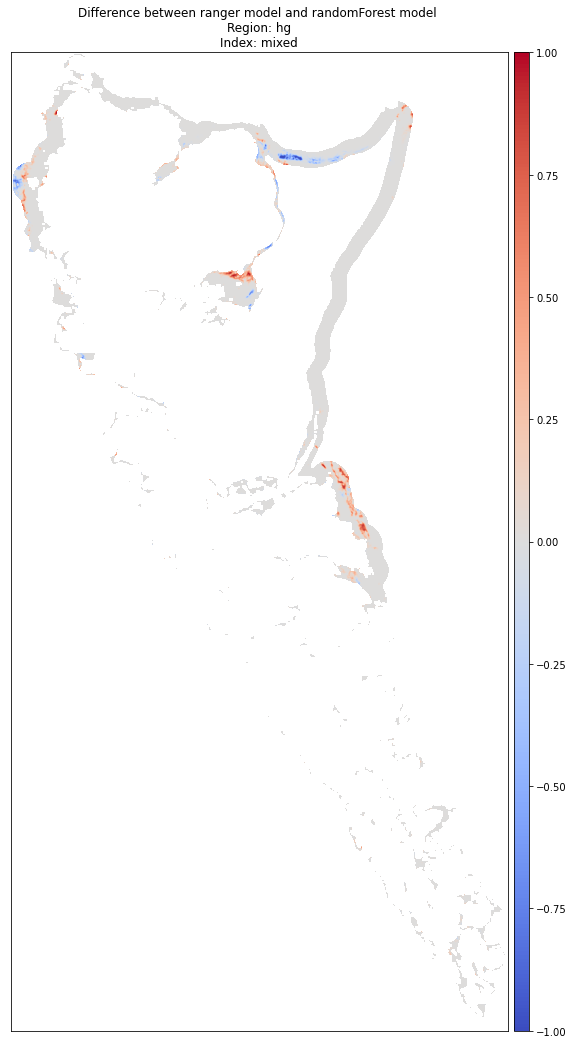

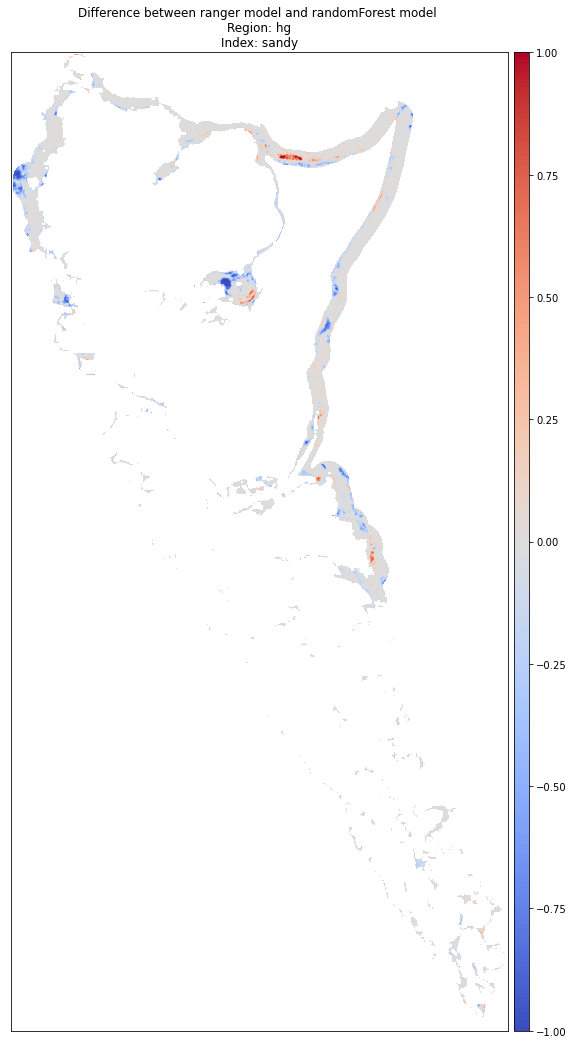

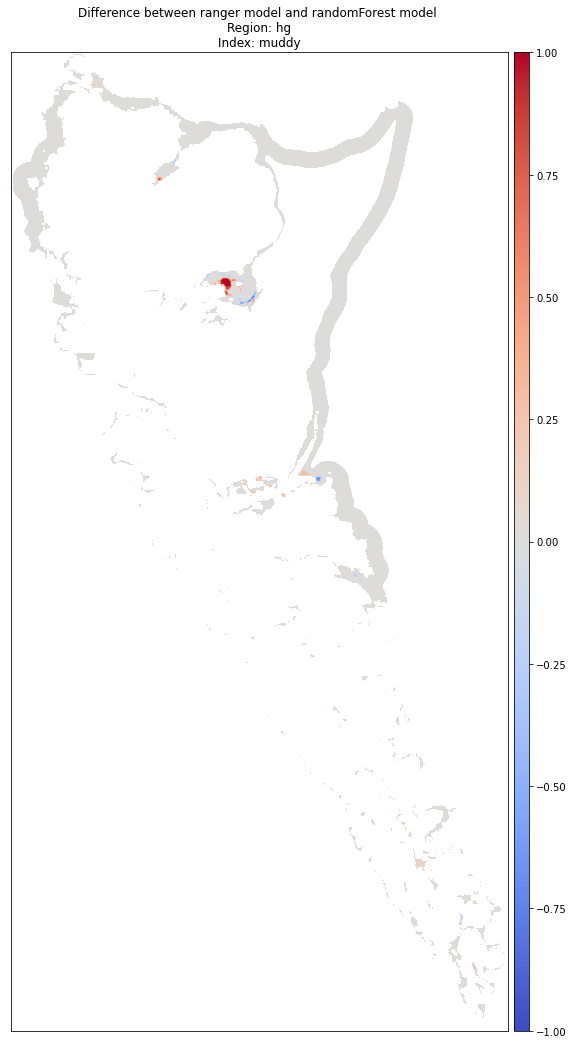

2021-01-11 09:24:43,372:INFO: - Getting names of GeoTIFFs...
2021-01-11 09:24:43,373:INFO: - Number of GeoTIFFS in D:\projects\substrate\rf-ranger-compare\data\output_hg: 5
2021-01-11 09:24:43,374:INFO: - Calculating statistics for example.tif...
2021-01-11 09:24:43,395:INFO: - Calculating statistics for hg_mixed_diff.tif...
2021-01-11 09:24:44,690:INFO: - Calculating statistics for hg_muddy_diff.tif...
2021-01-11 09:24:45,992:INFO: - Calculating statistics for hg_rocky_diff.tif...
2021-01-11 09:24:47,316:INFO: - Calculating statistics for hg_sandy_diff.tif...


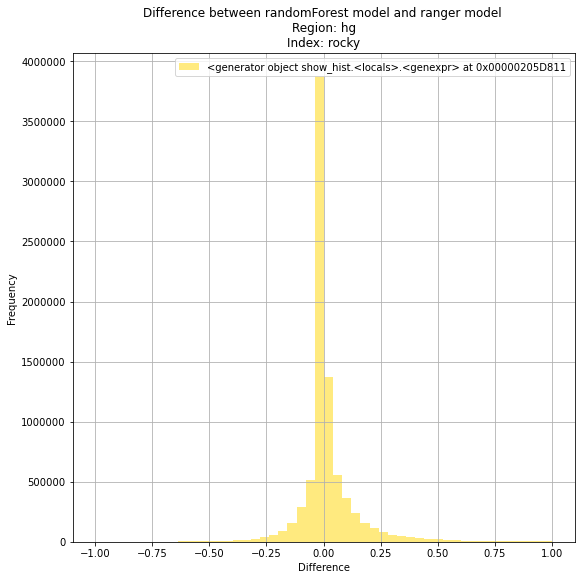

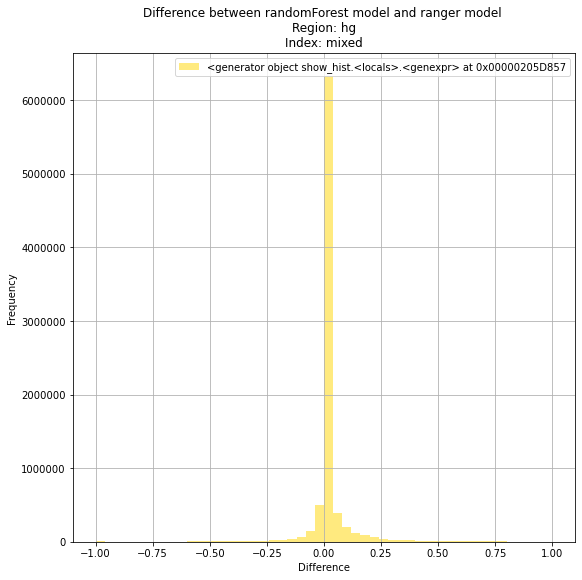

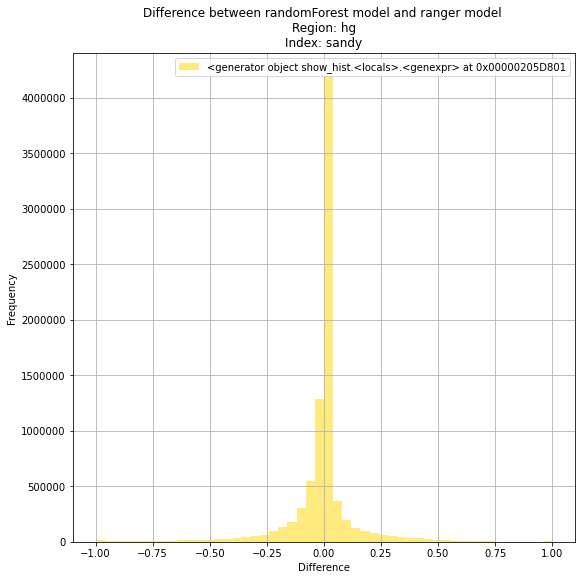

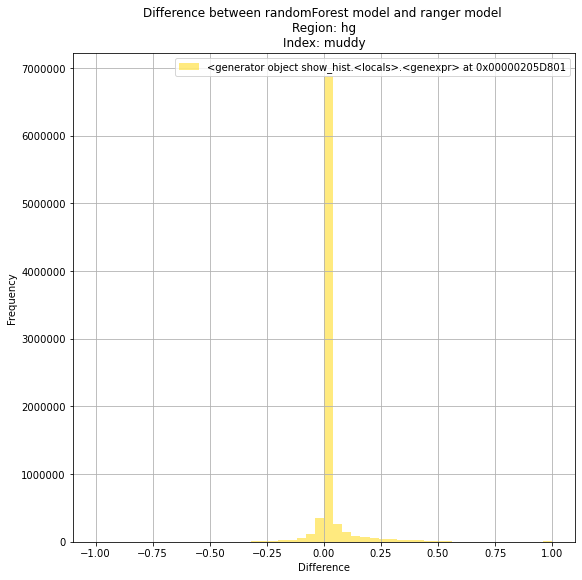

In [80]:
# prefix for region ("coast", "ncc", "hg", "qcs", "wcvi", "sog")
prefix = "hg"
# set output directory
out_dir = create_outdir(INPUT_DIRECTORY, prefix)
logging.info("Output directory: {}".format(out_dir))

# subset tiffs by method and region prefix
model_dicts = [subset_tiffs(INPUT_DIRECTORY, prefix, idx) for idx in INDEX_LYR]
# create difference arrays
diffs = [subtract_rasters(model_dict, INPUT_DIRECTORY, out_dir, prefix, idx) for model_dict, idx in zip(model_dicts, INDEX_LYR)] 
# plot results
plts = [plot_raster(array, prefix, idx, FIG_SIZE, out_dir) for array, idx in zip(diffs, INDEX_LYR)] 
# list of output tiffs
diff_tiffs = list_tiffs(out_dir)
# calc stats on output tiffs
stats = [calc_stats(tiff) for tiff in diff_tiffs]
# plot histograms of difference
hists = [hist(array, prefix, idx, 50, FIG_SIZE/2, out_dir) for array, idx in zip(diffs, INDEX_LYR)] 

## Queen Charlotte Strait <a class="anchor" id="Queen-Charlotte-Strait"></a>

2021-01-11 09:41:22,522:INFO: - Creating output directory: D:\projects\substrate\rf-ranger-compare\data\output_qcs
2021-01-11 09:41:22,523:INFO: - Changing directory to: D:\projects\substrate\rf-ranger-compare\data\output_qcs
2021-01-11 09:41:22,524:INFO: - Output directory: D:\projects\substrate\rf-ranger-compare\data\output_qcs
2021-01-11 09:41:22,525:INFO: - Subsetting GeoTIFFs by qcs and rocky...
2021-01-11 09:41:22,526:INFO: - rf: ['qcs_rocky_rf.tif']
2021-01-11 09:41:22,527:INFO: - ranger: ['qcs_rocky_ranger.tif']
2021-01-11 09:41:22,527:INFO: - Subsetting GeoTIFFs by qcs and mixed...
2021-01-11 09:41:22,528:INFO: - rf: ['qcs_mixed_rf.tif']
2021-01-11 09:41:22,528:INFO: - ranger: ['qcs_mixed_ranger.tif']
2021-01-11 09:41:22,528:INFO: - Subsetting GeoTIFFs by qcs and sandy...
2021-01-11 09:41:22,529:INFO: - rf: ['qcs_sandy_rf.tif']
2021-01-11 09:41:22,530:INFO: - ranger: ['qcs_sandy_ranger.tif']
2021-01-11 09:41:22,530:INFO: - Subsetting GeoTIFFs by qcs and muddy...
2021-01-11 09:

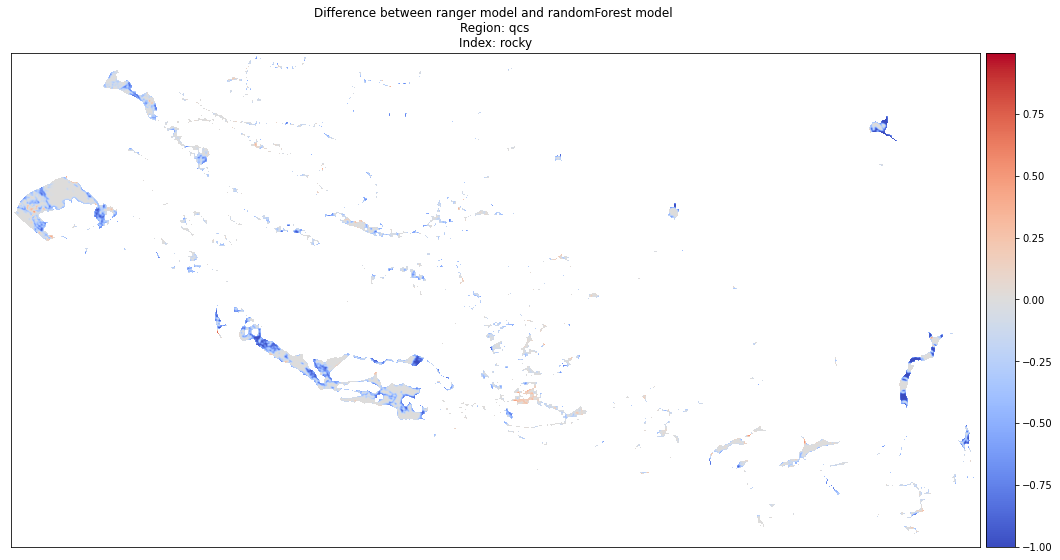

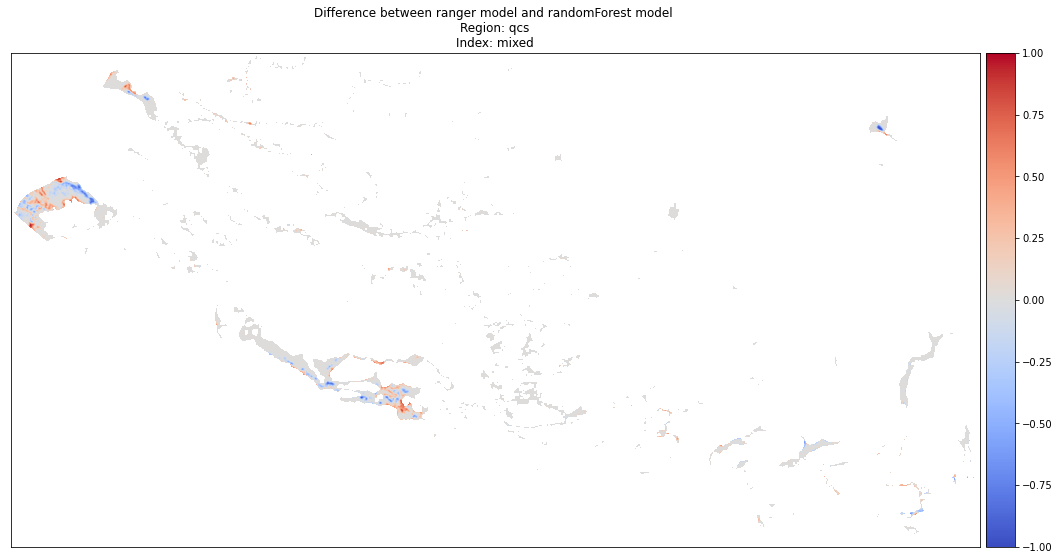

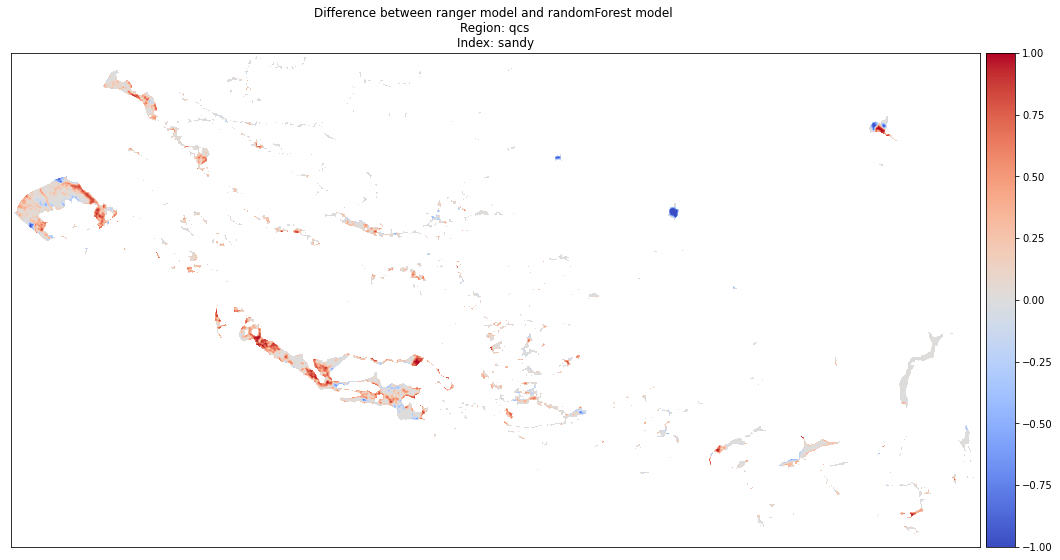

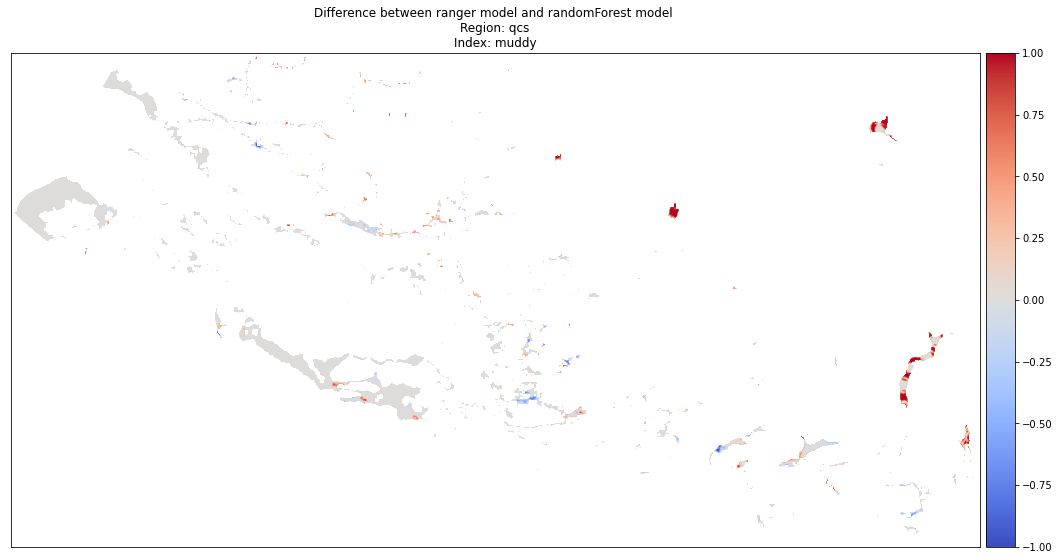

2021-01-11 09:42:04,310:INFO: - Getting names of GeoTIFFs...
2021-01-11 09:42:04,311:INFO: - Number of GeoTIFFS in D:\projects\substrate\rf-ranger-compare\data\output_qcs: 4
2021-01-11 09:42:04,311:INFO: - Calculating statistics for qcs_mixed_diff.tif...
2021-01-11 09:42:04,899:INFO: - Calculating statistics for qcs_muddy_diff.tif...
2021-01-11 09:42:05,502:INFO: - Calculating statistics for qcs_rocky_diff.tif...
2021-01-11 09:42:06,128:INFO: - Calculating statistics for qcs_sandy_diff.tif...


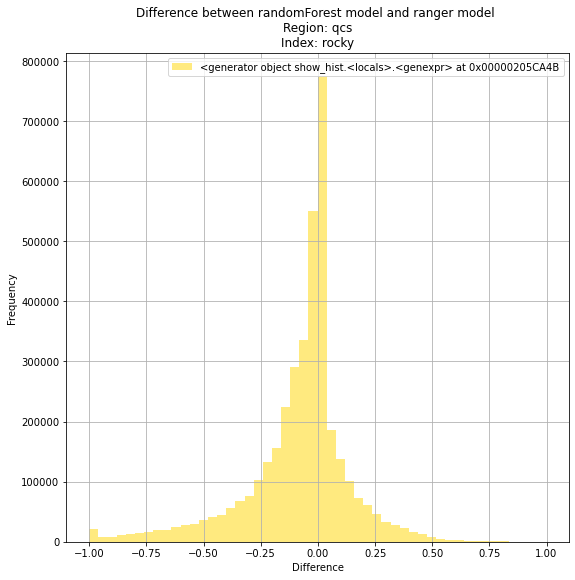

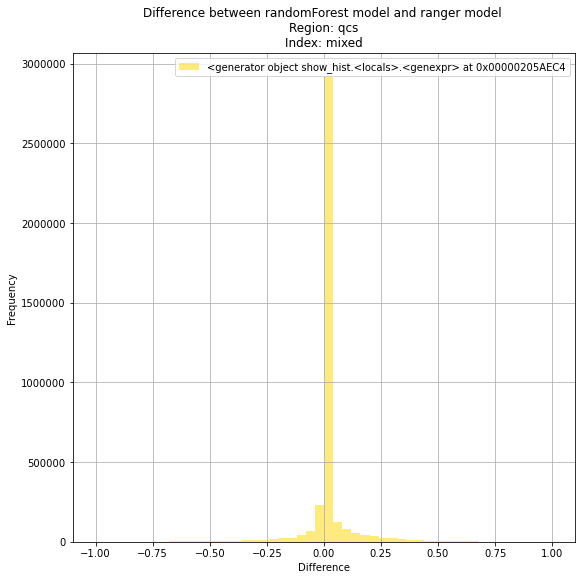

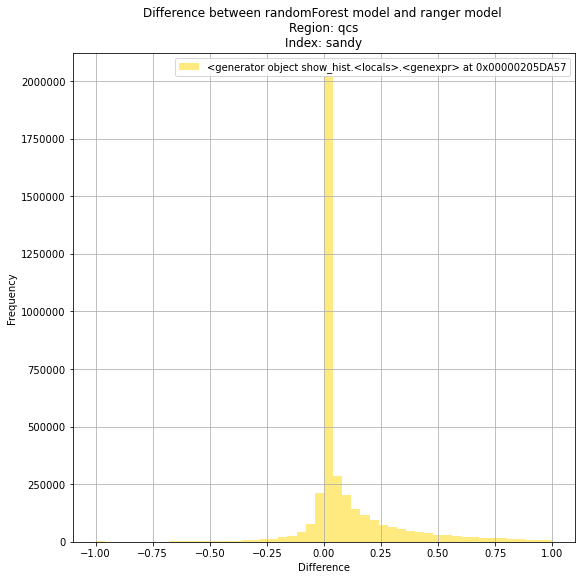

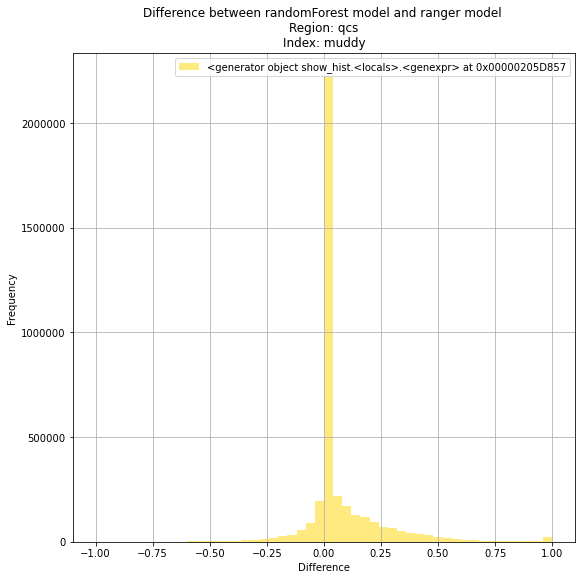

In [83]:
# prefix for region ("coast", "ncc", "hg", "qcs", "wcvi", "sog")
prefix = "qcs"
# set output directory
out_dir = create_outdir(INPUT_DIRECTORY, prefix)
logging.info("Output directory: {}".format(out_dir))

# subset tiffs by method and region prefix
model_dicts = [subset_tiffs(INPUT_DIRECTORY, prefix, idx) for idx in INDEX_LYR]
# create difference arrays
diffs = [subtract_rasters(model_dict, INPUT_DIRECTORY, out_dir, prefix, idx) for model_dict, idx in zip(model_dicts, INDEX_LYR)] 
# plot results
plts = [plot_raster(array, prefix, idx, FIG_SIZE, out_dir) for array, idx in zip(diffs, INDEX_LYR)] 
# list of output tiffs
diff_tiffs = list_tiffs(out_dir)
# calc stats on output tiffs
stats = [calc_stats(tiff) for tiff in diff_tiffs]
# plot histograms of difference
hists = [hist(array, prefix, idx, 50, FIG_SIZE/2, out_dir) for array, idx in zip(diffs, INDEX_LYR)] 

## North Central Coast <a class="anchor" id="North-Central-Coast">

2021-01-11 09:43:53,519:INFO: - Creating output directory: D:\projects\substrate\rf-ranger-compare\data\output_ncc
2021-01-11 09:43:53,520:INFO: - Changing directory to: D:\projects\substrate\rf-ranger-compare\data\output_ncc
2021-01-11 09:43:53,521:INFO: - Output directory: D:\projects\substrate\rf-ranger-compare\data\output_ncc
2021-01-11 09:43:53,522:INFO: - Subsetting GeoTIFFs by ncc and rocky...
2021-01-11 09:43:53,523:INFO: - rf: ['ncc_rocky_rf.tif']
2021-01-11 09:43:53,523:INFO: - ranger: ['ncc_rocky_ranger.tif']
2021-01-11 09:43:53,524:INFO: - Subsetting GeoTIFFs by ncc and mixed...
2021-01-11 09:43:53,525:INFO: - rf: ['ncc_mixed_rf.tif']
2021-01-11 09:43:53,525:INFO: - ranger: ['ncc_mixed_ranger.tif']
2021-01-11 09:43:53,526:INFO: - Subsetting GeoTIFFs by ncc and sandy...
2021-01-11 09:43:53,526:INFO: - rf: ['ncc_sandy_rf.tif']
2021-01-11 09:43:53,527:INFO: - ranger: ['ncc_sandy_ranger.tif']
2021-01-11 09:43:53,527:INFO: - Subsetting GeoTIFFs by ncc and muddy...
2021-01-11 09:

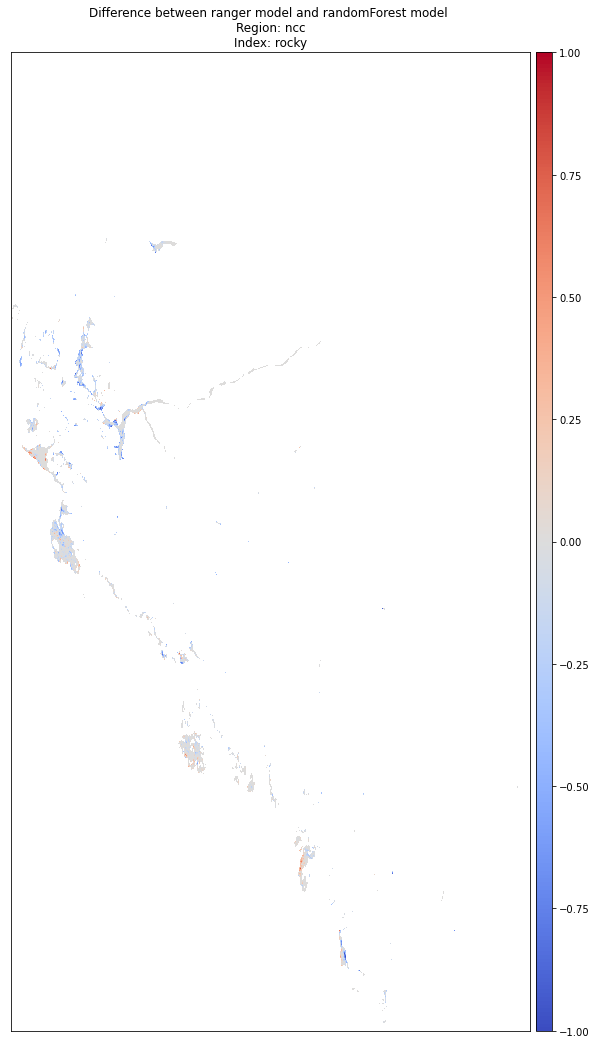

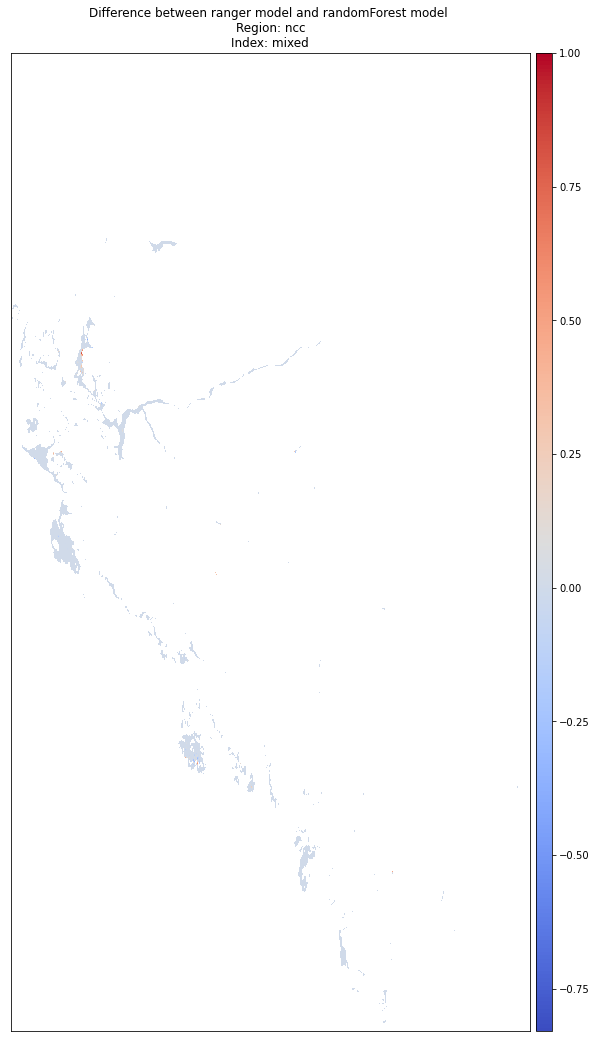

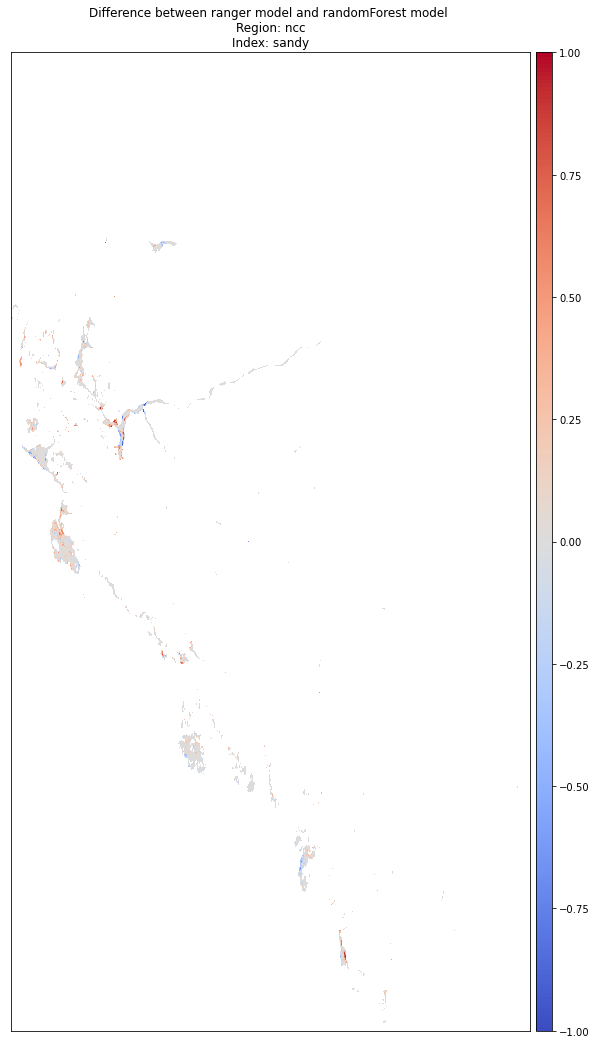

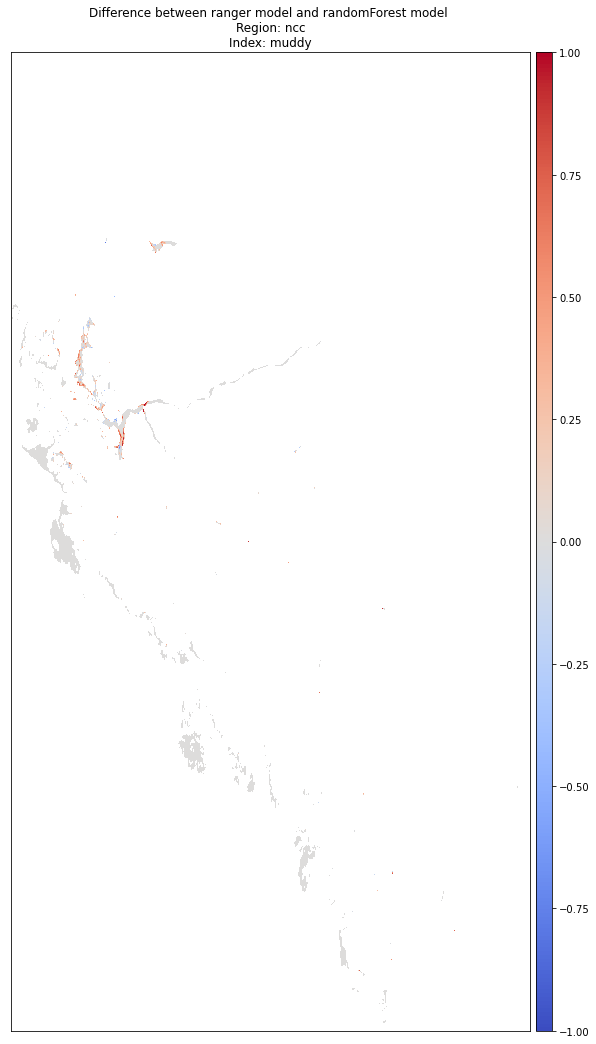

2021-01-11 09:48:17,952:INFO: - Getting names of GeoTIFFs...
2021-01-11 09:48:17,953:INFO: - Number of GeoTIFFS in D:\projects\substrate\rf-ranger-compare\data\output_ncc: 4
2021-01-11 09:48:17,953:INFO: - Calculating statistics for ncc_mixed_diff.tif...
2021-01-11 09:48:23,169:INFO: - Calculating statistics for ncc_muddy_diff.tif...
2021-01-11 09:48:28,453:INFO: - Calculating statistics for ncc_rocky_diff.tif...
2021-01-11 09:48:34,416:INFO: - Calculating statistics for ncc_sandy_diff.tif...


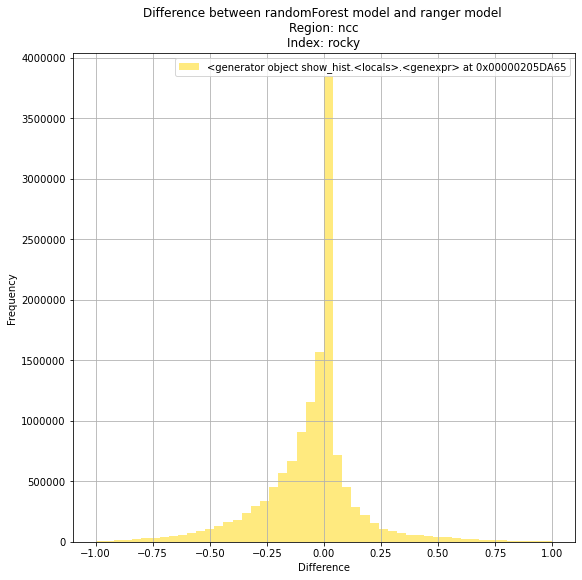

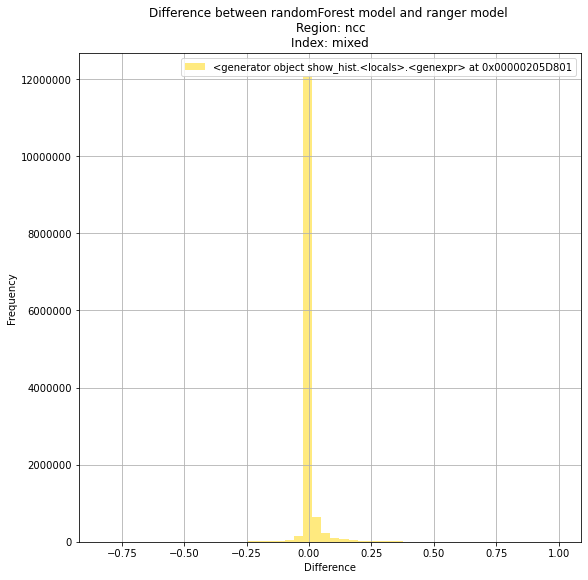

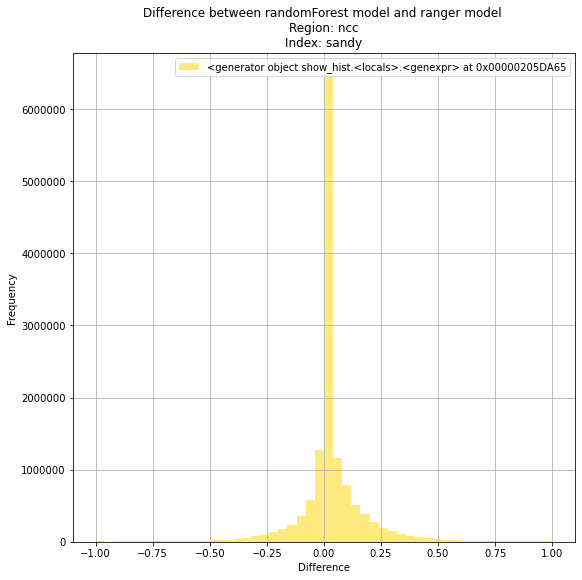

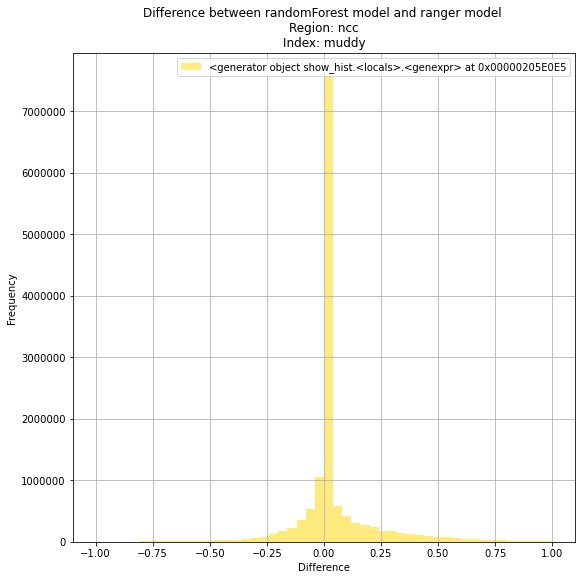

In [84]:
# prefix for region ("coast", "ncc", "hg", "qcs", "wcvi", "sog")
prefix = "ncc"
# set output directory
out_dir = create_outdir(INPUT_DIRECTORY, prefix)
logging.info("Output directory: {}".format(out_dir))

# subset tiffs by method and region prefix
model_dicts = [subset_tiffs(INPUT_DIRECTORY, prefix, idx) for idx in INDEX_LYR]
# create difference arrays
diffs = [subtract_rasters(model_dict, INPUT_DIRECTORY, out_dir, prefix, idx) for model_dict, idx in zip(model_dicts, INDEX_LYR)] 
# plot results
plts = [plot_raster(array, prefix, idx, FIG_SIZE, out_dir) for array, idx in zip(diffs, INDEX_LYR)] 
# list of output tiffs
diff_tiffs = list_tiffs(out_dir)
# calc stats on output tiffs
stats = [calc_stats(tiff) for tiff in diff_tiffs]
# plot histograms of difference
hists = [hist(array, prefix, idx, 50, FIG_SIZE/2, out_dir) for array, idx in zip(diffs, INDEX_LYR)] 